###  Computing spectral analysis on the data to estimate pairwise coherence

The methods to compute the spectral analysis can be imported as follows:

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')

import time
import h5py
import scipy
import numpy                 as     np
import xarray                as     xr
import matplotlib.pyplot     as     plt

from   GDa.session      import session

from scipy.signal       import fftconvolve, coherence

from mne.time_frequency import tfr_array_morlet, tfr_array_multitaper

from frites.io      import set_log_level, logger
from frites.utils   import parallel_func
from frites.dataset import SubjectEphy
from frites.config  import CONFIG

#### FRITES coherence methods

In [5]:
"""Compute the single trial coherence.
This script includes two types of single-trial coherence :
1. A instantaneous wavelet-based one
2. A Welch's PSD-based one using sliding windows
"""
# Authors : Vinicius Lima <vinicius.lima.cordeiro@gmail.com >
#           Etienne Combrisson <e.combrisson@gmail.com>
#
# License : BSD (3-clause)

import numpy as np
from scipy.signal import fftconvolve, coherence
import xarray as xr

from mne.time_frequency import tfr_array_morlet, tfr_array_multitaper

from frites.io import set_log_level, logger
from frites.utils import parallel_func
from frites.dataset import SubjectEphy
from frites.config import CONFIG


###############################################################################
###############################################################################
#                           WAVELET BASED COHERENCE
###############################################################################
###############################################################################


def _tf_decomp(data, sf, freqs, mode='morlet', n_cycles=7.0, mt_bandwidth=None,
               decim=1, kw_cwt={}, kw_mt={}, n_jobs=1):
    """Time-frequency decomposition using MNE-Python.
    Parameters
    ----------
    data : array_like
        Electrophysiological data of shape (n_trials, n_chans, n_times)
    sf : float
        Sampling frequency
    freqs : array_like
        Central frequency vector.
    mode : {'morlet', 'multitaper'}
        Spectrum estimation mode can be either: 'multitaper' or 'morlet'.
    n_cycles : array_like | 7.
        Number of cycles to use for each frequency. If a float or an integer is
        used, the same number of cycles is going to be used for all frequencies
    mt_bandwidth : array_like | None
        The bandwidth of the multitaper windowing function in Hz. Only used in
        'multitaper' mode.
    decim : int | 1
        To reduce memory usage, decimation factor after time-frequency
        decomposition. default 1 If int, returns tfr[…, ::decim]. If slice,
        returns tfr[…, decim].
    kw_cwt : dict | {}
        Additional arguments sent to the mne-function
        :py:`mne.time_frequency.tfr_array_morlet`
    kw_mt : dict | {}
        Additional arguments sent to the mne-function
        :py:`mne.time_frequency.tfr_array_multitaper`
    Returns
    -------
    out : array_like
        Time-frequency transform of shape (n_epochs, n_chans, n_freqs, n_times)
    """
    if mode == 'morlet':
        out = tfr_array_morlet(
            data, sf, freqs, n_cycles=n_cycles, output='complex', decim=decim,
            n_jobs=n_jobs, **kw_cwt)
    elif mode == 'multitaper':
        out = tfr_array_multitaper(
            data, sf, freqs, n_cycles=n_cycles, time_bandwidth=mt_bandwidth,
            output='complex', decim=decim, n_jobs=n_jobs, **kw_mt)
    else:
        raise ValueError('Method should be either "morlet" or "multitaper"')

    return out


def _create_kernel(sm_times, sm_freqs, kernel='hanning'):
    """2D (freqs, time) smoothing kernel.
    Parameters
    ----------
    sm_times : int
        Number of points to consider for the temporal smoothing
    sm_freqs : int
        Number of points to consider for the frequency smoothing
    kernel : {'square', 'hanning'}
        Kernel type to use. Choose either 'square' or 'hanning'
    Returns
    -------
    kernel : array_like
        Smoothing kernel of shape (sm_freqs, sm_times)
    """
    if kernel == 'square':
        return np.full((sm_freqs, sm_times), 1. / (sm_times * sm_freqs))
    elif kernel == 'hanning':
        hann_t, hann_f = np.hanning(sm_times), np.hanning(sm_freqs)
        hann = hann_f.reshape(-1, 1) * hann_t.reshape(1, -1)
        return hann / np.sum(hann)
    else:
        raise ValueError(f"No kernel {kernel}")


def _smooth_spectra(spectra, kernel):
    """Smoothing spectra.
    This function assumes that the frequency and time axis are respectively
    located at positions (..., freqs, times).
    Parameters
    ----------
    spectra : array_like
        Spectra of shape (..., n_freqs, n_times)
    kernel : array_like
        Smoothing kernel of shape (sm_freqs, sm_times)
    Returns
    -------
    sm_spectra : array_like
        Smoothed spectra of shape (..., n_freqs, n_times)
    """
    while kernel.ndim != spectra.ndim:
        kernel = kernel[np.newaxis, ...]
    #return fftconvolve(spectra, kernel, mode='same', axes=(-2, -1))
    return np.apply_along_axis(np.convolve, -1, spectra, kernel.squeeze(), mode='same')


def conn_coherence_wav(
    data, freqs=None, roi=None, times=None, sfreq=None, pairs=None,
    win_sample=None, foi=None, sm_times=10, sm_freqs=1, sm_kernel='hanning',
    mode='morlet', n_cycles=7., mt_bandwidth=None, decim=1, edges=None,
    kw_cwt={}, kw_mt={}, block_size=None, n_jobs=-1, verbose=None):
    """Wavelet-based single-trial time-resolved pairwise coherence.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    freqs : array_like
        Array of frequencies.
    roi : array_like | None
        ROI names of a single subject. If the input is an xarray, the
        name of the ROI dimension can be provided
    times : array_like | None
        Time vector array of shape (n_times,). If the input is an xarray, the
        name of the time dimension can be provided
    sfreq : float
        The sampling frequency
    pairs : array_like | None
        Pairs of contacts
    win_sample : array_like | None
        Array of shape (n_windows, 2) in order to take the mean of the
        estimated coherence inside sliding windows. You can use the function
        :func:`frites.conn.define_windows` to define either manually either
        sliding windows.
    foi : array_like | None
        Extract frequencies of interest. This parameters should be an array of
        shapes (n_freqs, 2) defining where each band of interest start and
        finish.
    sm_times : int
        Number of points to consider for the temporal smoothing
    sm_freqs : int
        Number of points to consider for the frequency smoothing
    kernel : {'square', 'hanning'}
        Kernel type to use. Choose either 'square' or 'hanning'
    mode : {'morlet', 'multitaper'}
        Spectrum estimation mode can be either: 'multitaper' or 'morlet'.
    n_cycles : array_like | 7.
        Number of cycles to use for each frequency. If a float or an integer is
        used, the same number of cycles is going to be used for all frequencies
    mt_bandwidth : array_like | None
        The bandwidth of the multitaper windowing function in Hz. Only used in
        'multitaper' mode.
    decim : int | 1
        To reduce memory usage, decimation factor after time-frequency
        decomposition. default 1 If int, returns tfr[…, ::decim]. If slice,
        returns tfr[…, decim].
    edges : int | None
        Number of time points to discard in order to control for filtering
        leakage over the edges.
    kw_cwt : dict | {}
        Additional arguments sent to the mne-function
        :py:`mne.time_frequency.tfr_array_morlet`
    kw_mt : dict | {}
        Additional arguments sent to the mne-function
        :py:`mne.time_frequency.tfr_array_multitaper`
    block_size : int | None
        Number of blocks of trials to process at once. This parameter can be
        use in order to decrease memory load. If None, all trials are used. If
        for example block_size=2, the number of trials are subdivided into two
        groups and each group is process one after the other.
    n_jobs : int | 1
        Number of jobs to use for parallel computing (use -1 to use all
        jobs). The parallel loop is set at the pair level.
    Returns
    -------
    coh : xarray.DataArray
        DataArray of shape (n_trials, n_pairs, n_freqs, n_times)
    """
    set_log_level(verbose)

    # ___________________________________ I/O _________________________________
    if isinstance(data, xr.DataArray):
        trials, attrs = data[data.dims[0]].data, data.attrs
    else:
        trials, attrs = np.arange(data.shape[0]), {}

    # internal conversion
    data = SubjectEphy(data, y=trials, roi=roi, times=times, sfreq=sfreq)
    x, roi, times = data.data, data['roi'].data, data['times'].data[::decim]
    trials, sfreq = data['y'].data, data.attrs['sfreq']
    n_trials, n_roi, n_times = data.shape

    # inputs checking
    assert isinstance(freqs, (np.ndarray, list, tuple))
    freqs = np.array(freqs)
    n_freqs = len(freqs)

    # get the sorted non-directed pairs and build roi pairs names
    if (pairs is None):
        x_s, x_t = np.triu_indices(n_roi, k=1)
    else:
        assert isinstance(pairs, np.ndarray)
        assert (pairs.ndim == 2) and (pairs.shape[1] == 2)
        x_s, x_t = pairs[:, 0], pairs[:, 1]
    roi_s, roi_t = np.sort(np.c_[roi[x_s], roi[x_t]], axis=1).T
    roi_p = [f"{s}-{t}" for s, t in zip(roi_s, roi_t)]
    n_pairs = len(roi_p)

    # build block size indices
    if isinstance(block_size, int) and (block_size > 1):
        indices = np.array_split(np.arange(n_trials), block_size)
    else:
        indices = [np.arange(n_trials)]

    # temporal mean
    need_mean = isinstance(win_sample, np.ndarray) and win_sample.shape[1] == 2
    if need_mean:
        if decim > 2:
            win_sample = np.floor(win_sample / decim).astype(int)
        times = times[win_sample].mean(1)

    # drop edges
    if isinstance(edges, int):
        times = times[edges:-edges]

    # adapt temporal smoothing to decimation factor
    sm_times = int(np.round(sm_times / decim))

    # kernel smoothing definition
    kernel = _create_kernel(sm_times, sm_freqs, kernel=sm_kernel)

    # frequency mean
    need_foi = isinstance(foi, np.ndarray) and foi.shape[1] == 2
    if need_foi:
        _f = xr.DataArray(np.arange(len(freqs)), dims=('freqs',),
                          coords=(freqs,))
        foi_s = _f.sel(freqs=foi[:, 0], method='nearest').data
        foi_e = _f.sel(freqs=foi[:, 1], method='nearest').data
        foi_idx = np.c_[foi_s, foi_e]
        f_vec = freqs[foi_idx].mean(1)
    else:
        f_vec = freqs

    # show info
    logger.info(f"Compute pairwise coherence (n_pairs={n_pairs}, "
                f"n_freqs={n_freqs})")

    coh = []
    for tr in indices:
        # ___________________________ TIME-FREQUENCY __________________________
        # time-frequency decomposition
        w = _tf_decomp(
            x[tr, ...], sfreq, freqs, n_cycles=n_cycles, decim=decim,
            mode=mode, mt_bandwidth=mt_bandwidth, kw_cwt=kw_cwt, kw_mt=kw_mt,
            n_jobs=n_jobs)

        # drop edges
        if isinstance(edges, int):
            w = w[..., edges:-edges]

        # ______________________________ COHERENCY ____________________________
        # auto spectra (faster that w * w.conj())
        s_auto = w.real ** 2 + w.imag ** 2
        # smooth the auto spectra
        s_auto = _smooth_spectra(s_auto.reshape((s_auto.shape[0],s_auto.shape[1],s_auto.shape[2]*s_auto.shape[3])),
                                 kernel).reshape((s_auto.shape[0],s_auto.shape[1],s_auto.shape[2],s_auto.shape[3]))

        def pairwise_coherence(w_x, w_y):
            # computes the coherence
            s_xy = w[:, w_y, :, :] * np.conj(w[:, w_x, :, :])
            s_xy = _smooth_spectra(s_xy.reshape((s_xy.shape[0],s_xy.shape[1]*s_xy.shape[2])), 
                                   kernel).reshape((s_xy.shape[0],s_xy.shape[1],s_xy.shape[2]))
            s_xx = s_auto[:, w_x, :, :]
            s_yy = s_auto[:, w_y, :, :]
            coh = np.abs(s_xy) ** 2 / (s_xx * s_yy)

            # mean inside temporal sliding window (if needed)
            if need_mean:
                coh_w = []
                for w_s, w_e in win_sample:
                    coh_w += [coh[..., w_s:w_e].mean(-1, keepdims=True)]
                coh = np.concatenate(coh_w, axis=-1)

            # mean inside frequency sliding window (if needed)
            if need_foi:
                coh_f = []
                for f_s, f_e in foi_idx:
                    coh_f += [coh[:, f_s:f_e, :].mean(-2, keepdims=True)]
                coh = np.concatenate(coh_f, axis=-2)

            return coh

        # define the function to compute in parallel
        parallel, p_fun = parallel_func(
            pairwise_coherence, n_jobs=n_jobs, verbose=verbose,
            total=n_pairs)

        # compute the single trial coherence
        coh_tr = parallel(p_fun(s, t) for s, t in zip(x_s, x_t))
        coh += [np.stack(coh_tr, axis=1)]
    coh = np.concatenate(coh, axis=0)


    # ________________________________ DATAARRAY ______________________________
    # configuration
    cfg = dict(
        sfreq=sfreq, sm_times=sm_times, sm_freqs=sm_freqs, sm_kernel=sm_kernel,
        mode=mode, n_cycles=n_cycles, mt_bandwidth=mt_bandwidth, decim=decim
    )
    # conversion
    coh = xr.DataArray(coh, dims=('trials', 'roi', 'freqs', 'times'),
                       name='coh', coords=(trials, roi_p, f_vec, times),
                       attrs=cfg)
    return coh


###############################################################################
###############################################################################
#                             PSD BASED COHERENCE
###############################################################################
###############################################################################


def _coherence_psd(x_s, x_t, win_sample, foi, **kw_coh):
    """Compute the coherence for a single pair of channels."""
    coh = []
    for t_s, t_e in win_sample:
        # compute the coherence
        _x_s, _x_t = x_s[..., t_s:t_e], x_t[..., t_s:t_e]
        _, _coh = coherence(_x_s, _x_t, **kw_coh)
        # mean inside frequency bands (if needed)
        if isinstance(foi, np.ndarray):
            _coh_f = []
            for f_s, f_e in foi:
                _coh_f += [_coh[..., f_s:f_e].mean(-1, keepdims=True)]
            _coh = np.concatenate(_coh_f, axis=-1)
        coh += [_coh]
    return np.stack(coh, axis=-1)


def conn_coherence_psd(
        data, roi=None, times=None, sfreq=None, pairs=None, win_sample=None,
        foi=None, block_size=None, n_jobs=-1, kw_coh={}, verbose=None):
    """Welch PSD-based single-trial pairwise coherence.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    roi : array_like | None
        ROI names of a single subject. If the input is an xarray, the
        name of the ROI dimension can be provided
    times : array_like | None
        Time vector array of shape (n_times,). If the input is an xarray, the
        name of the time dimension can be provided
    sfreq : float
        The sampling frequency
    pairs : array_like | None
        Pairs of contacts
    win_sample : array_like | None
        Array of shape (n_windows, 2) describing where each window start and
        finish. You can use the function :func:`frites.conn.define_windows`
        to define either manually either sliding windows. If None, the entire
        time window is used instead.
    foi : array_like | None
        Extract frequencies of interest. This parameters should be an array of
        shapes (n_freqs, 2) defining where each band of interest start and
        finish.
    block_size : int | None
        Number of blocks of trials to process at once. This parameter can be
        use in order to decrease memory load. If None, all trials are used. If
        for example block_size=2, the number of trials are subdivided into two
        groups and each group is process one after the other.
    n_jobs : int | 1
        Number of jobs to use for parallel computing (use -1 to use all
        jobs). The parallel loop is set at the pair level.
    kw_coh : dict | {}
        Additional arguments to send to the function
        :py:`scipy.signal.coherence`
    Returns
    -------
    coh : xarray.DataArray
        DataArray of shape (n_trials, n_pairs, n_freqs, n_windows)
    """
    set_log_level(verbose)

    # ___________________________________ I/O _________________________________
    if isinstance(data, xr.DataArray):
        trials, attrs = data[data.dims[0]].data, data.attrs
    else:
        trials, attrs = np.arange(data.shape[0]), {}

    # internal conversion
    data = SubjectEphy(data, y=trials, roi=roi, times=times, sfreq=sfreq)
    x, roi, times = data.data, data['roi'].data, data['times'].data
    trials, sfreq = data['y'].data, data.attrs['sfreq']
    n_trials, n_roi, n_times = data.shape

    # get the sorted non-directed pairs and build roi pairs names
    if (pairs is None):
        x_s, x_t = np.triu_indices(n_roi, k=1)
    else:
        assert isinstance(pairs, np.ndarray)
        assert (pairs.ndim == 2) and (pairs.shape[1] == 2)
        x_s, x_t = pairs[:, 0], pairs[:, 1]
    roi_s, roi_t = np.sort(np.c_[roi[x_s], roi[x_t]], axis=1).T
    roi_p = [f"{s}-{t}" for s, t in zip(roi_s, roi_t)]
    n_pairs = len(roi_p)

    # deal with the win_sample array
    if win_sample is None:
        win_sample = np.array([[0, len(times) - 1]])
    assert isinstance(win_sample, np.ndarray) and (win_sample.ndim == 2)
    assert win_sample.dtype in CONFIG['INT_DTYPE']
    n_win = win_sample.shape[0]

    # build block size indices
    if isinstance(block_size, int) and (block_size > 1):
        indices = np.array_split(np.arange(n_trials), block_size)
    else:
        indices = [np.arange(n_trials)]

    # show info
    logger.info(f"Compute pairwise coherence (n_pairs={n_pairs}, n_windows="
                f"{n_win})")

    # ________________________________ COHERENCY ______________________________
    kw_coh.update(dict(axis=-1, fs=sfreq))

    # dry run to get the frequency vector
    sl = slice(win_sample[0, 0], win_sample[0, 1])
    freqs, _ = coherence(x[0, 0, sl], x[0, 1, sl], **kw_coh)

    # frequency mean
    need_foi = isinstance(foi, np.ndarray) and foi.shape[1] == 2
    if need_foi:
        _f = xr.DataArray(np.arange(len(freqs)), dims=('freqs',),
                          coords=(freqs,))
        foi_s = _f.sel(freqs=foi[:, 0], method='nearest').data
        foi_e = _f.sel(freqs=foi[:, 1], method='nearest').data
        foi = np.c_[foi_s, foi_e]
        freqs = freqs[foi].mean(1)

    # real computations
    parallel, p_fun = parallel_func(
        _coherence_psd, n_jobs=n_jobs, verbose=verbose,
        total=n_pairs)

    # loop over block of trials
    coh = []
    for tr in indices:
        _coh = parallel(p_fun(x[tr, s, :], x[tr, t, :], win_sample, foi,
                              **kw_coh) for s, t in zip(x_s, x_t))
        coh += [np.stack(_coh, axis=1)]
    coh = np.concatenate(coh, axis=0)

    # ________________________________ DATAARRAY ______________________________
    win_times = times[win_sample].mean(1)
    coh = xr.DataArray(coh, dims=('trials', 'roi', 'freqs', 'times'),
                       name='coh', coords=(trials, roi_p, freqs, win_times))

    return coh

### Loading data

In [6]:
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])
ses.read_from_mat()

### Multitaper estimation (averaging over sub-bands)

- band $1$  = [0.1,6]  Hz;
- band $2$  = [6,14]   Hz;
- band $3$  = [14,26]  Hz;
- band $4$  = [26,42]  Hz;
- band $5$  = [42,80]  Hz;

In [7]:
f_start, f_end, n_freqs, sfreq = .1, 80, 50, 1000
freqs = np.linspace(f_start, f_end, n_freqs, endpoint=True)
foi   = np.array([
            [0.1, 6.],
            [6., 14.],
            [14., 26.],
            [26., 42.],
            [42., 80.]
                ])

# define temporal windows + compute the DFC
n_cycles = freqs / 2.

kw = dict(
    freqs=freqs, times='times', roi=None, foi=foi, n_jobs=-1,
    sfreq=sfreq, mode='multitaper', n_cycles=n_cycles, decim=10,
    sm_times=300, sm_freqs=1, block_size=2, edges=None
)

# compute the coherence
coh = conn_coherence_wav(ses.data.values, **kw).astype(np.float32)

WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1176, n_freqs=50)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   40.6s remaining:   58.8s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   42.7s remaining:   27.0s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   44.7s remaining:   10.1s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   57.8s finished


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   42.6s remaining:  1.0min
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   44.7s remaining:   28.3s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   46.8s remaining:   10.5s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   59.6s finished


The auto spectra can be computed as tem elementwise product of $W$ and its conjugate:

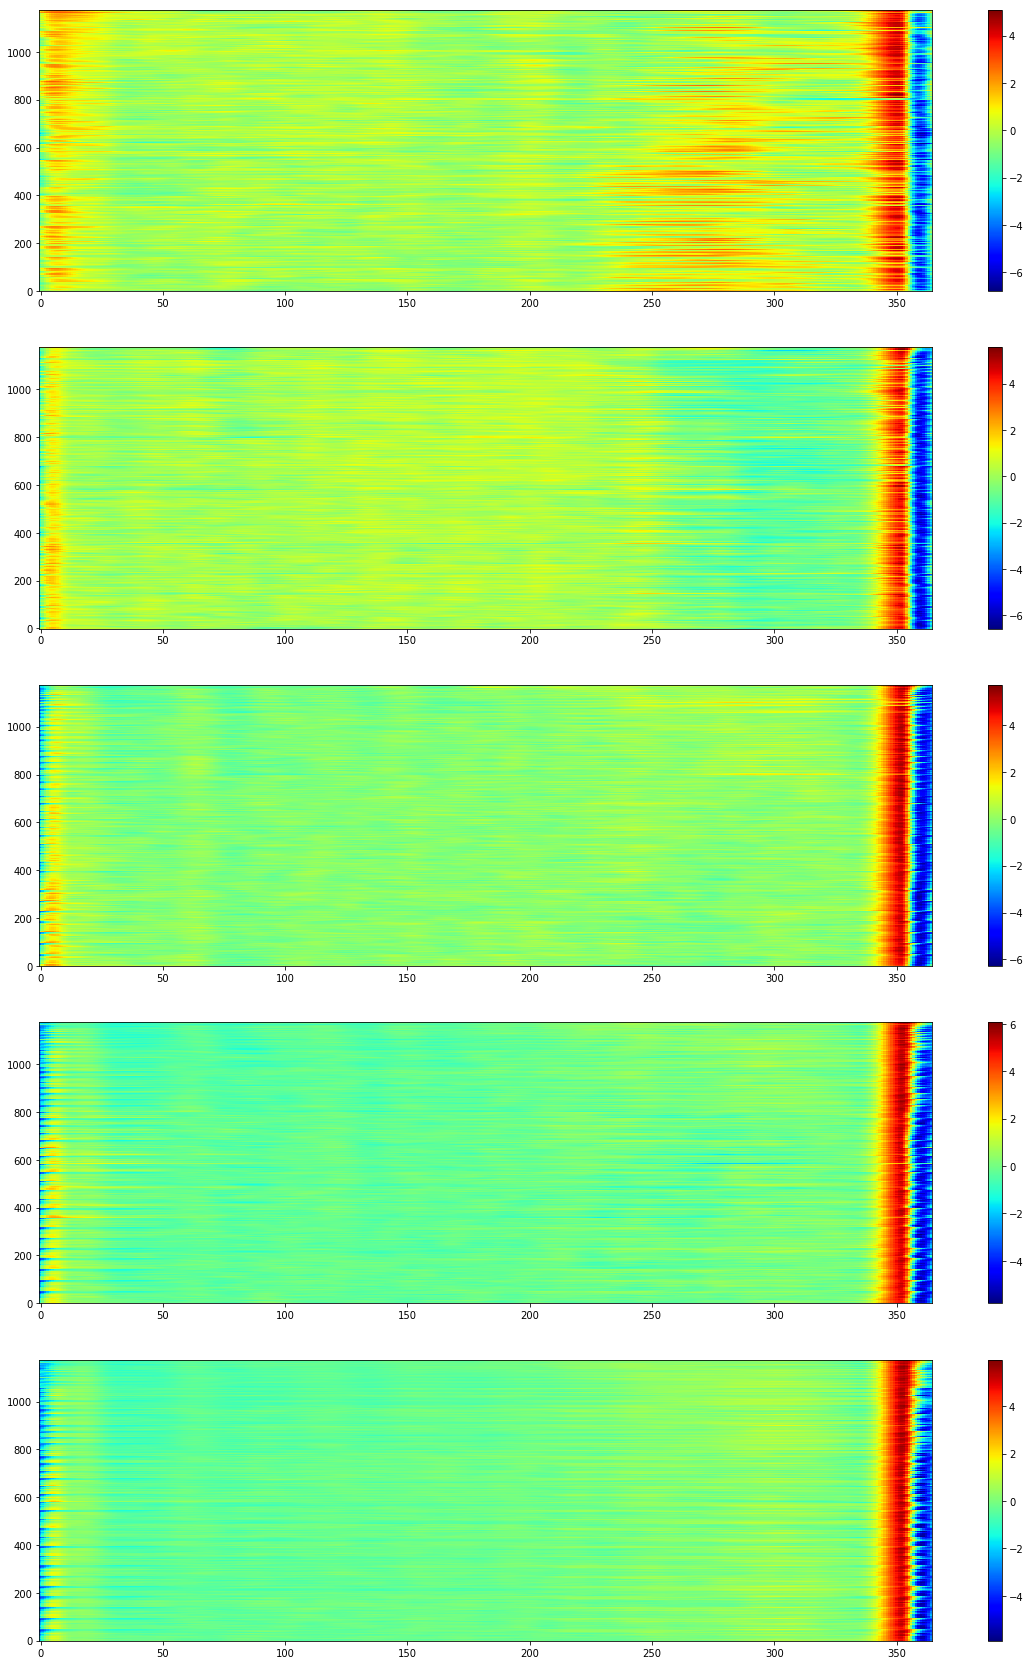

In [8]:
plt.figure(figsize=(20,30))
for i in range(foi.shape[0]):
    aux = coh.mean(dim='trials')[:,i,:]
    aux = (aux-aux.mean(dim='times'))/aux.std(dim='times')
    plt.subplot(foi.shape[0],1,i+1)
    plt.imshow(aux,aspect='auto', cmap='jet',origin='lower')
    plt.colorbar()

### Multitaper estimation (computing directly for each foi)

In [9]:
sfreq = 1000
foi   = np.array([
            [0.1, 6.],
            [6., 14.],
            [14., 26.],
            [26., 42.],
            [42., 80.]
                ])

freqs = foi.mean(axis=1)
d_f   = np.ceil( (np.array(foi)[:,1]-np.array(foi)[:,0])/2 )

# define temporal windows + compute the DFC
n_cycles = 4 * freqs / d_f

kw = dict(
    freqs=freqs, times='times', roi=None, foi=None, n_jobs=-1,
    sfreq=sfreq, mode='multitaper', n_cycles=n_cycles, decim=10,
    sm_times=300, sm_freqs=1, block_size=2, edges=None
)

# compute the coherence
coh = conn_coherence_wav(ses.data.values, **kw).astype(np.float32)

WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1176, n_freqs=5)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   10.4s remaining:   15.1s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   10.8s remaining:    6.8s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   11.0s remaining:    2.5s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   12.5s finished


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   10.6s remaining:   15.3s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   11.0s remaining:    6.9s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   11.3s remaining:    2.5s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   12.5s finished


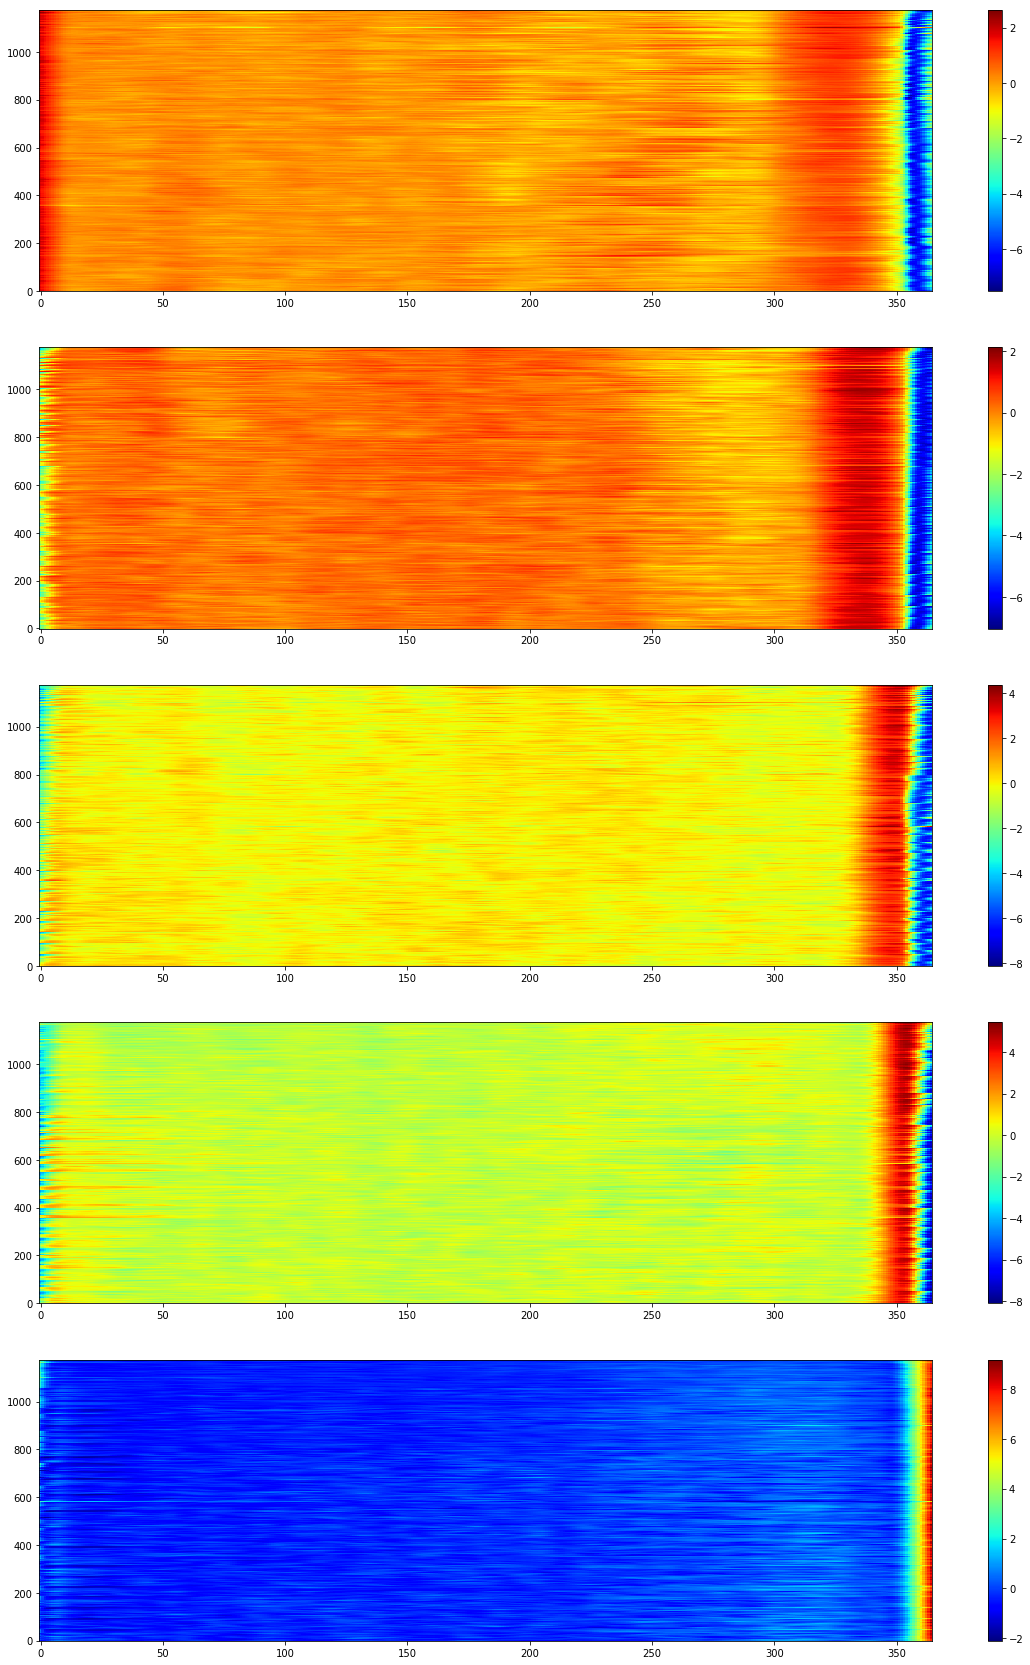

In [10]:
plt.figure(figsize=(20,30))
for i in range(foi.shape[0]):
    aux = coh.mean(dim='trials')[:,i,:]
    aux = (aux-aux.mean(dim='times'))/aux.std(dim='times')
    plt.subplot(foi.shape[0],1,i+1)
    plt.imshow(aux,aspect='auto', cmap='jet',origin='lower')
    plt.colorbar()